### Домашнее задание "Случайные марковские процессы"


- Скачайте текст войны и мир. Очистите его, оставив только русские буквы и символы пробела. Постройте матрицу переходных вероятностей. Посчитайте вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р; Используя матрицу переходных вероятностей сгенерируйте слово, начинающееся с буквы “Б” и имеющее длину 8-мь символов

- Выберите ряд из предыдущих домашних заданий по временным рядам и оцените его через HMM. Попробуйте “построить” (через среднее каждой компоненты) наивный прогноз ряда.

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
%matplotlib inline
sns.set()

In [2]:
# читаем все 4 тома,
folder="voina_i_mir"
list_of_files = os.listdir(folder)
text=''
for file in list_of_files:
    print(f'reading {file}')
    with open(folder+'/'+file, 'r', encoding="utf8") as f:
        text += f.read().lower()

reading tom_1.txt
reading tom_2.txt
reading tom_3.txt
reading tom_4.txt


In [3]:
text_cleaned = re.sub('[^a-я ]','', text)

In [4]:
text_cleaned[:100]

'annotationлев толстойвойна и миртом   том iчасть перваяiiiiiiivvviviiviiiixxxixiixiiixivxvxvixviixvi'

In [5]:
text_cleaned = re.sub('[a-z]','', text_cleaned)

In [6]:
text_cleaned[:100]

'лев толстойвойна и миртом   том часть перваячасть ораячасть третья  том лев николаевич толстойвойна '

Замена переносов строки пустой строкой слепила некоторые слова в одно слово. Очистим текст заново, но вначале заменим переносы строк пробелами. Дополнительно замечу, что в книге много текста на французском, записанного, соответственно, латиницей, но эти фрагменты текста я тоже вырежу, оставив только русский текст

In [7]:
text[:100]

'annotation\n\n\nлев толстой\n\nвойна и мир\n\nтом 1\n\n\n\n\n\n* * *\n\n\n\nтом iчасть перваяi\n\nii\n\niii\n\niv\n\nv\n\nvi\n\nv'

In [8]:
ALPHABET = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя '
POS = {l: i for i, l in enumerate(ALPHABET)}

In [9]:
text_cleaned = re.sub(r'\n+', ' ', text)
text_cleaned = re.sub(r'[^{}]'.format(ALPHABET),'', text_cleaned)
text_cleaned = ' '.join(text_cleaned.split()) 

In [10]:
text_cleaned[:100]

'лев толстой война и мир том том часть первая часть орая часть третья том лев николаевич толстой войн'

In [11]:
probabilities = np.zeros((len(ALPHABET), len(ALPHABET)))

In [12]:
for cp, cn in zip(text_cleaned[:-1], text_cleaned[1:]):
    probabilities[POS[cp], POS[cn]] += 1

In [13]:
probabilities

array([[2.2000e+01, 1.6260e+03, 8.7790e+03, ..., 2.0510e+03, 6.4260e+03,
        4.5519e+04],
       [2.6090e+03, 2.4000e+01, 2.1500e+02, ..., 1.1000e+01, 1.1720e+03,
        6.0300e+02],
       [1.4789e+04, 3.6000e+01, 8.9000e+01, ..., 1.0000e+00, 5.5200e+02,
        1.7519e+04],
       ...,
       [2.0000e+00, 1.1170e+03, 0.0000e+00, ..., 9.9000e+01, 0.0000e+00,
        7.9990e+03],
       [2.0000e+00, 1.0200e+02, 7.7700e+02, ..., 3.1500e+02, 4.4100e+02,
        2.9624e+04],
       [6.2690e+03, 1.9650e+04, 4.0748e+04, ..., 8.7000e+01, 3.7790e+03,
        0.0000e+00]])

In [14]:
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

In [15]:
df = pd.DataFrame(probabilities, index=(c for c in ALPHABET), columns=(c for c in ALPHABET))

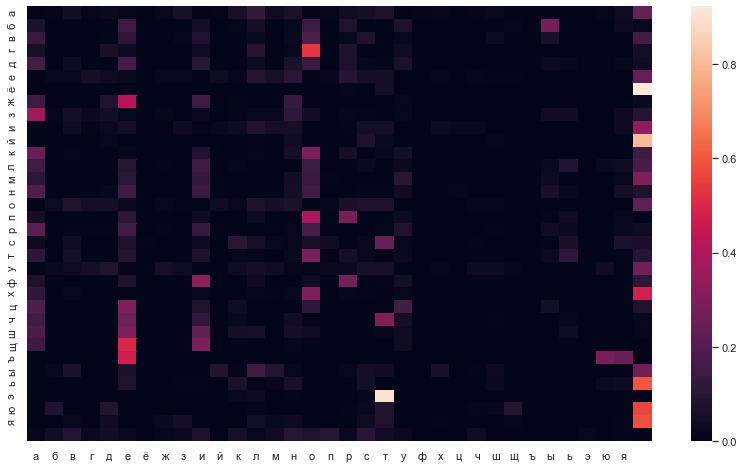

In [16]:
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

На тепловой карте видим несколько достаточно логичных корреляций. Так после буквы Ъ с большой вероятностью пойдет одна из йотированных гласных (но не ё) в соответствии с правилами русского языка. После Э с высокой долей вероятности идет буква Т: указательные местоимения "это", "этот" и пр. используются часто, а в остальном Э - редкая в употреблениии буква. Можем убедиться, что школьные правила типа ЖИ ШИ или ЧА ЩА вполне работают, судя по этой визуализации. И т.д. 

#### Посчитать вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р

In [17]:
start = POS['п']
end = POS['р']
prior = 1. / len(ALPHABET)
total=0
word_probas={}

for c1 in ALPHABET:
    for c2 in ALPHABET:
        proba = prior * probabilities[start, POS[c1]] * probabilities[POS[c1], POS[c2]] * probabilities[POS[c2], end]
        total+= proba
        if proba > 0:
            word_probas[''.join(['п', c1,c2,'р'])]=proba

print(f'Вероятность встретить строку из 4 символов от "п" до "р" = {total}')

Вероятность встретить строку из 4 символов от "п" до "р" = 0.0009527010137051277


In [18]:
sorted_tuples = sorted(word_probas.items(), key=lambda item: item[1], reverse=True)
sorted_word_probas = {k: v for k, v in sorted_tuples}

for k, v in sorted_word_probas.items():
    print(f'Наиболее вероятная комбинация "{k}", её вероятность = {v}')
    break

Наиболее вероятная комбинация "прер", её вероятность = 0.0001197434635517545


#### Сгенерировать слово, начинающееся с буквы “Б” и имеющее длину 8-мь символов

Запускаю в цикле, чтобы посмотреть на несколько попыток

In [39]:
for n in range(10):
    s = []
    start = 'б' 
    s.append(start)
    length = 7
    for i in range(length):
        index = POS[s[i]]
        next_char = np.random.choice(list(ALPHABET), p=probabilities[index])
        s.append(next_char)

    print (n+1, ''.join(s))

1 бролакре
2 бубрымей
3 бала ист
4 бя к гчт
5 бовся и 
6 бы этаси
7 бони ани
8 быел али
9 бутей ль
10 бы дрчта


Если хотим целое слово без пробелов, немного модифицируем код

In [31]:
for n in range(10):
    s = []
    start = 'б' 
    s.append(start)
    length = 7
    for i in range(length):
        index = POS[s[i]]
        next_char = ' '
        while next_char==' ':
            next_char = np.random.choice(list(ALPHABET), p=probabilities[index])
        s.append(next_char)

    print (n+1, ''.join(s))

1 быбушиор
2 боробыхо
3 бомехале
4 блестоги
5 бысесьма
6 бамуянен
7 бытерест
8 брапросе
9 биломале
10 бепрылон


In [48]:
for n in range(10):
    s = []
    start = 'п' 
    s.append(start)
    length = 7
    for i in range(length):
        index = POS[s[i]]
        next_char = ' '
        while next_char==' ':
            next_char = np.random.choice(list(ALPHABET), p=probabilities[index])
        s.append(next_char)

    print (n+1, ''.join(s))

1 придумас
2 поляняхо
3 питьстас
4 почтьцот
5 прумидор
6 пядашака
7 прамнина
8 пратеяду
9 пульсяде
10 полкибок


Вижу, что много слов, в которых после Б идет Ы. По матрице переходных вероятностей видно, что Ы и есть наиболее вероятная буква, следующая за Б, из всех.   
А так, конечно, странно было бы ожидать, что сгенерируется что-то совсем осмысленное, но получившиеся слова в целом похожи на слова русского языка 

В качестве эксперимента пробую построить матрицу переходов между словами, а не между буквами, и сгенерировать несколько предложений на её основе. Это не являются частью основного задания, но любопытно посмотреть, что из этого получится

In [7]:
text_list = text_cleaned.split()

In [8]:
uniq_words = set(text_list)

In [9]:
POS_WORD = {l: i for i, l in enumerate(uniq_words)}

In [10]:
len(uniq_words)

49428

In [11]:
probabilities_word = np.zeros((len(uniq_words), len(uniq_words)), dtype='uint8')

In [12]:
for cp, cn in zip(text_list[:-1], text_list[1:]):
    probabilities_word[POS_WORD[cp], POS_WORD[cn]] += 1

In [13]:
probabilities_word = (probabilities_word / probabilities_word.sum(axis=1)[:, None])

In [27]:
for n in range(10):
    s = []
    start = np.random.choice(list(uniq_words))
    s.append(start)
    length = np.random.choice(list(range(5, 10)))
    for i in range(length):
        index = POS_WORD[s[i]]
        next_word = np.random.choice(list(uniq_words), p=probabilities_word[index])
        s.append(next_word)

    print (n+1, ' '.join(s))

1 затруднил бы княжна марья дмитриевна о великом отчаянном
2 уведомлял ее оставили витебск старый князь багратион с противодвижением
3 поколений от этой комнате тогда когда
4 рюмкой подошел к замолкнувшему или нет а не
5 накрывал ночной рубашкой тихон что нужно подчиняться обаянию весны лес
6 жила целую и отдохнуть ваша милая княжна марья передала ридикюль
7 исправлявший черную небольшую улицу деревни микулиной к
8 восторгом совершенно седым усом особенно резко закричал
9 конето каков багратион наклонил голову за
10 побледнел и судьею он достал изза сарая через


Опять же не очень осмысленно, но некоторые паттерны прослеживаются даже здесь. Например, персонажи, имена которых состоят из нескольких слов, вида "княжна Марья", она же "Марья Дмитриевна", "князь Багратион" должны часто упоминаться в исходном тексте именно в таком виде, соответственно, эти пары слов мы здесь и видим.  

#### Выбрать ряд из предыдущих домашних заданий по временным рядам и оценить его через HMM. Попробовать “построить” (через среднее каждой компоненты) наивный прогноз ряда

In [53]:
! pip install hmmlearn

In [54]:
from hmmlearn.hmm import GaussianHMM

In [55]:
ts = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")["Deg"]

In [56]:
values = ts.values.reshape(-1,1)

In [61]:
for n in range(1, 11):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(values)
    print (n, model.score(values))

1 -855.6201905961935
2 -767.9220576513211
3 -729.7130998068989
4 -698.3653054078605
5 -659.626887181372
6 -662.2169048916919
7 -623.318205067524
8 -602.2719528668746
9 -595.1311563191472
10 -575.3994839744757


Text(0.5, 1.0, 'Number of components=3')

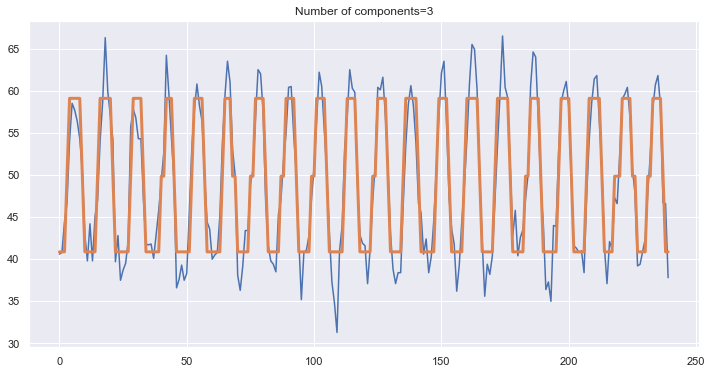

In [66]:
model = GaussianHMM(n_components=3,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)
plt.title('Number of components=3')

Text(0.5, 1.0, 'Number of components=7')

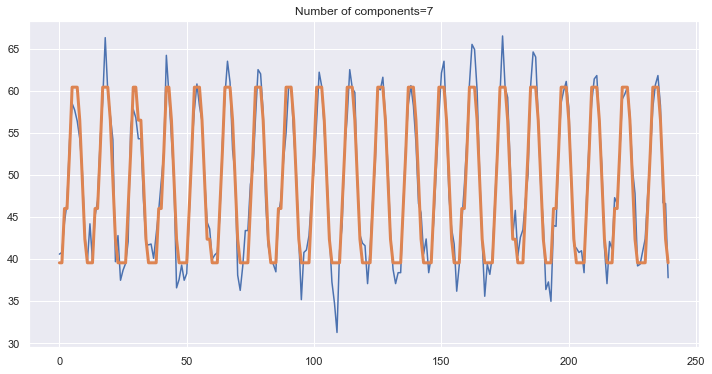

In [67]:
model = GaussianHMM(n_components=7,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)
plt.title('Number of components=7')

Text(0.5, 1.0, 'Number of components=10')

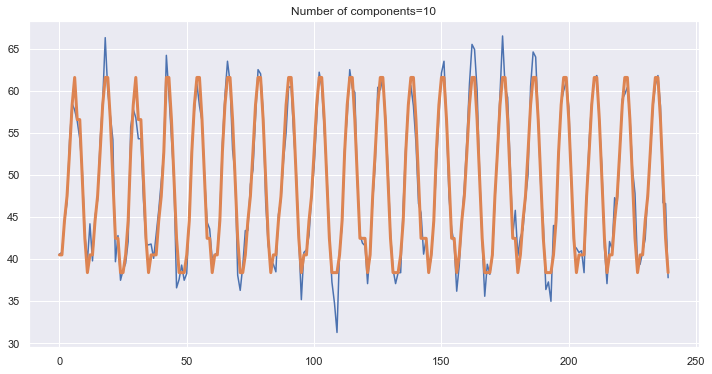

In [68]:
model = GaussianHMM(n_components=10,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)
plt.title('Number of components=10')

Все варианты уловили общее поведение ряда. Выбор количества компонент будет зависеть от необходимой степени точности